# Ewaluacja predykcji szeregów czasowych

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

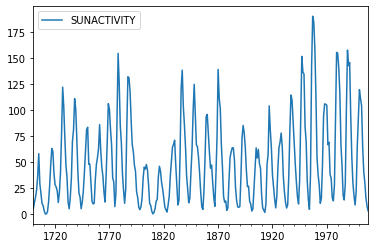

In [3]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
sunspots = sunspots.drop('YEAR', axis=1)

sunspots.plot()

### Podział na część treningową i część testową

Ocena dokładności na podstawie tych samych danych, które były wykorzystane do konstrukcji prognozu, nie pozwala na w pełni wiarygodną ocenę skuteczności i może prowadzić do błędnych wniosków. Aby wiarygodnie porównać skuteczność różnych metod prognozowania, powinniśmy wykorzystać niezależne dane testowe.

W tym celu szereg dzielimy na:
- **część treningową** - wykorzystaną do dopasowania modelu i konstrukcji prognoz,
- **część testową** - wykorzystaną do oceny dokładności prognoz.

In [4]:
k = int(sunspots.size * 0.8)

sunspots_train = sunspots[:k]
sunspots_test = sunspots[k:]

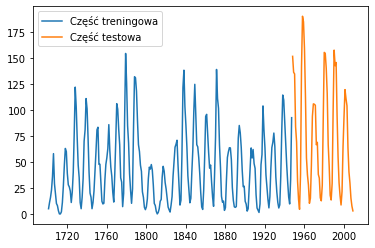

In [5]:
plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.legend()
plt.show()

In [6]:
np.min(sunspots_test.index), np.max(sunspots_test.index)

(Timestamp('1947-12-31 00:00:00'), Timestamp('2008-12-31 00:00:00'))

In [7]:
arma42 = ARIMA(sunspots_train, order=(4, 0, 2)).fit()
arma42_predict = arma42.predict(start='1947', end='2008', dynamic=True)

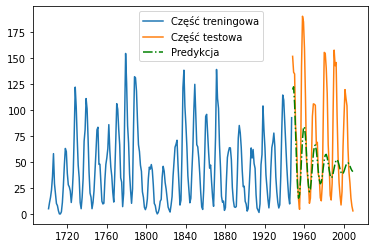

In [8]:
plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma42_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

## Zadanie 1

Napisz funkcję, która znajdzie najlepszy model ARMA - pamiętaj o podziale zbioru na część treningową i testową.

In [9]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [10]:
def find_the_best_arma(ts, max_p = 10, max_q=10, split=0.8):
    
    k = int(ts.size * split)
    ts_train = ts[:k]
    ts_test = ts[k:]

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    mse2 = np.zeros((max_p, max_q))
    mae2 = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                arma = ARIMA(ts_train, order=(i + 1, 0, j + 1)).fit()
                aic[i, j] = arma.aic
                bic[i, j] = arma.bic
                print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))

                arma_pred = arma.predict(start=str(np.min(ts_test.index).year), end=str(np.max(ts_test.index).year), 
                                         dynamic=True)
                mse2[i, j] = mse(ts_test.values, arma_pred.values)
                mae2[i, j] = mae(ts_test.values, arma_pred.values)
            except:
                aic[i, j] = bic[i, j] = mse2[i, j] = mae2[i, j] = np.Inf
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))
    
    min_mse = np.min(mse2)
    min_arg_mse = np.argwhere(mse2 == min_mse)[0]
    print("MINIMUM MSE=%f dla p=%d, q=%d" % (min_mse, min_arg_mse[0] + 1, min_arg_mse[1] + 1))
    
    min_mae = np.min(mae2)
    min_arg_mae = np.argwhere(mae2 == min_mae)[0]
    print("MINIMUM MAE=%f dla p=%d, q=%d" % (min_mae, min_arg_mae[0] + 1, min_arg_mae[1] + 1))

In [ ]:
find_the_best_arma(sunspots, 5, 5) #szukamy modelu o najlepszym AIC, BIC, MSE i MAE (te dwie ostatnie wyliczone na zbiorze testowym)

ARMA(1, 1): AIC=2106.036510, BIC=2120.074064
ARMA(1, 2): AIC=2070.118592, BIC=2087.665534
ARMA(1, 3): AIC=2065.739210, BIC=2086.795540
ARMA(1, 4): AIC=2062.390795, BIC=2086.956514
ARMA(1, 5): AIC=2060.321158, BIC=2088.396265
ARMA(2, 1): AIC=2039.591641, BIC=2057.138583
ARMA(2, 2): AIC=2041.541968, BIC=2062.598298
ARMA(2, 3): AIC=2043.524369, BIC=2068.090088
ARMA(2, 4): AIC=2031.548344, BIC=2059.623450
ARMA(3, 1): AIC=2040.483338, BIC=2061.539668
ARMA(3, 2): AIC=2042.359549, BIC=2066.925267
ARMA(3, 3): AIC=2043.738003, BIC=2071.813110
ARMA(3, 4): AIC=2018.724167, BIC=2050.308662
ARMA(3, 5): AIC=2033.804698, BIC=2068.898581
ARMA(4, 1): AIC=2042.393166, BIC=2066.958885
ARMA(4, 2): AIC=2018.456907, BIC=2046.532013
ARMA(4, 3): AIC=2044.777291, BIC=2076.361786
ARMA(4, 4): AIC=2018.446382, BIC=2053.540265
ARMA(4, 5): AIC=2021.458067, BIC=2060.061338
ARMA(5, 1): AIC=2043.183914, BIC=2071.259020
ARMA(5, 2): AIC=2034.727663, BIC=2066.312158
ARMA(5, 3): AIC=2026.914281, BIC=2062.008164
ARMA(5, 4)

In [ ]:
k = int(sunspots.size * 0.8)
sunspots_train = sunspots[:k]
sunspots_test = sunspots[k:] #dzielimy w taki sposób, aby pokrywało się to z tym co w find_the_best_arma

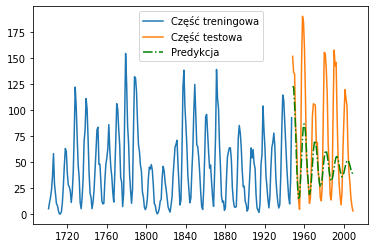

In [ ]:
arma55 = ARIMA(sunspots_train, order=(5, 0, 5)).fit()
arma55_predict = arma55.predict(start='1947', end='2008', dynamic=True)

plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma55_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

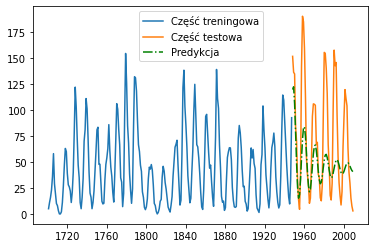

In [ ]:
arma42 = ARIMA(sunspots_train, order=(4, 0, 2)).fit()
arma42_predict = arma42.predict(start='1947', end='2008', dynamic=True)

plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma42_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

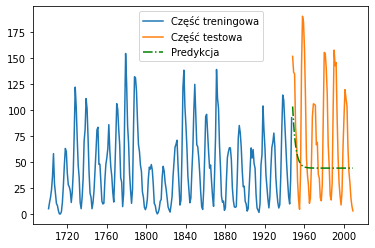

In [ ]:
arma11 = ARIMA(sunspots_train, order=(1, 0, 1)).fit()
arma11_predict = arma11.predict(start='1947', end='2008', dynamic=True)

plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma11_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

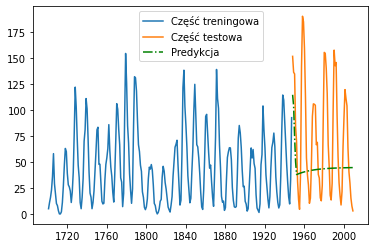

In [ ]:
arma15 = ARIMA(sunspots_train, order=(1, 0, 5)).fit()
arma15_predict = arma15.predict(start='1947', end='2008', dynamic=True)

plt.plot(sunspots_train, label="Część treningowa")
plt.plot(sunspots_test, label="Część testowa")
plt.plot(arma15_predict, 'g-.', label="Predykcja")
plt.legend()
plt.show()

In [ ]:
#lepsze dwa pierwsze modele

## Kroswalidacja

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

TRAIN: (0, 77)
TEST: (78, 154)


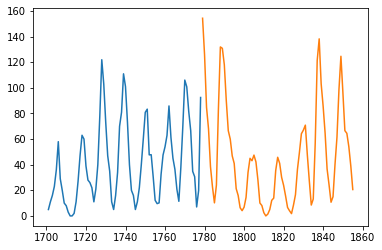

TRAIN: (0, 154)
TEST: (155, 231)


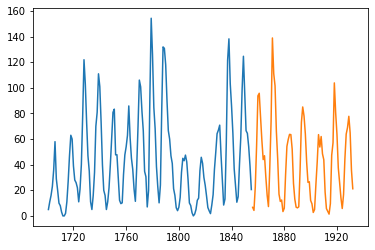

TRAIN: (0, 231)
TEST: (232, 308)


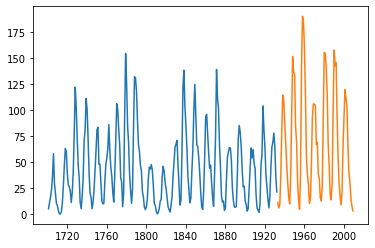

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(sunspots.values):
    print("TRAIN: (%d, %d)" % (min(train_index), max(train_index)))
    print("TEST: (%d, %d)" % (min(test_index), max(test_index)))
    
    train, test = sunspots.iloc[train_index], sunspots.iloc[test_index]
    plt.plot(train)
    plt.plot(test)
    plt.show()

In [ ]:
#kroswalidacja w szeregach czasowych wygląda nieco inaczej na początek bierzemy pierwszą jedną czwartą zbioru do uczenia i kolejną jedną czwartą do testowego
#następnie bierzemy pierwszą dwie czwarte zbioru do uczenia i kolejną jedną czwartą do testowego
#na koniec pierwszą trzy czwarte zbioru do uczenia i ostatnią jedną czwartą do testowego

## Zadanie 2

Napisz funkcję, która znajdzie najlepszy model ARMA - użyj kroswalidacji.

In [ ]:
def find_the_best_arma_crossal(ts, max_p = 10, max_q=10, ar = False, cross=5):
    tscv = TimeSeriesSplit(n_splits=cross)
    
    aic = np.zeros((max_p + 1, max_q + 1))
    bic = np.zeros((max_p + 1, max_q + 1))
    mae_values = np.zeros((max_p + 1, max_q + 1))
    mse_values = np.zeros((max_p + 1, max_q + 1))
    
    for i in range(max_p + 1):
        for j in range(max_q + 1):
            if (i == j == 0):
                aic[0, 0] = bic[0, 0] = mae_values[0, 0] = mse_values[0, 0] = np.Inf
            elif (i == 0) | ((not ar) & (j == 0)):
                aic[i, j] = bic[i, j] = mae_values[i, j] = mse_values[i, j] = np.Inf
            else:
                aic_cross, bic_cross, mse_cross, mae_cross = [], [], [], []
                for train_index, test_index in tscv.split(ts.values):
                    train, test = ts.iloc[train_index], ts.iloc[test_index]
                    arma = ARIMA(train, order=(i, 0, j)).fit()
                    aic_cross.append(arma.aic)
                    bic_cross.append(arma.bic)
                    pred = arma.predict(start=str(np.min(test.index).year), end=str(np.max(test.index).year), dynamic=True)
                    mse_cross.append(mse(test.values, pred.values))
                    mae_cross.append(mae(test.values, pred.values))
                    
                aic[i, j] = np.mean(aic_cross)
                bic[i, j] = np.mean(arma.bic)
                mae_values[i, j] = np.nanmean(mae_cross)
                mse_values[i, j] = np.nanmean(mse_cross)
                print("ARMA(%d, %d): AIC=%f; BIC=%f; MSE=%f; MAE=%f" % (i, j, arma.aic, arma.bic, 
                                                                        mse_values[i, j], mae_values[i, j]))

    print("-" * 30)
    min_aic = np.nanmin(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0] 
    print("MINIMUM AIC=%f for p=%d, q=%d" % (min_aic, min_arg_aic[0], min_arg_aic[1]))
    
    min_bic = np.nanmin(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0] 
    print("MINIMUM BIC=%f for p=%d, q=%d" % (min_bic, min_arg_bic[0], min_arg_bic[1]))
    
    min_mse = np.nanmin(mse_values)
    min_arg_mse = np.argwhere(mse_values == min_mse)[0]
    print("MINIMUM MSE=%f for p=%d, q=%d" % (min_mse, min_arg_mse[0], min_arg_mse[1]))
    
    min_mae = np.nanmin(mae_values)
    min_arg_mae = np.argwhere(mae_values == min_mae)[0]
    print("MINIMUM MAE=%f for p=%d, q=%d" % (min_mae, min_arg_mae[0], min_arg_mae[1]))

In [ ]:
k = int(sunspots.size * 0.9)

sunspots_train = sunspots[:k]
sunspots_test = sunspots[k:]

find_the_best_arma_crossal(sunspots_train, 3, 3, cross=4)
#tutaj mamy to zrobione dokładnie tak jak powinniśmy przeprowadzać dopasowanie modelu. Dzielimy zbiór na treningowy i testowy
#na treningowym robimy kroswalidację to znaczy w każdym obrocie pętli na części zbioru dopasowujemy model a na kolejnej części licząc na niej MSE, czy MAE sprawdzamy
#który z modeli jest najlepszy
#później użyjemy testowego, który nie był w kroswalidacji do sprawdzenia jakości predykcji 

ARMA(1, 1): AIC=1902.762927; BIC=1916.391614; MSE=1702.121447; MAE=25.603712
ARMA(1, 2): AIC=1871.780311; BIC=1888.816170; MSE=1683.167923; MAE=25.988516
ARMA(1, 3): AIC=1868.624655; BIC=1889.067686; MSE=1680.065095; MAE=26.034466
ARMA(2, 1): AIC=1847.607253; BIC=1864.643112; MSE=1658.832458; MAE=26.486434
ARMA(2, 2): AIC=1849.437828; BIC=1869.880858; MSE=1660.214927; MAE=26.472607
ARMA(2, 3): AIC=1851.376935; BIC=1875.227137; MSE=1680.062456; MAE=26.208751
ARMA(3, 1): AIC=1848.043020; BIC=1868.486051; MSE=1656.798393; MAE=26.422455
ARMA(3, 2): AIC=1849.925074; BIC=1873.775277; MSE=1657.123772; MAE=26.434088
ARMA(3, 3): AIC=1851.512706; BIC=1878.770080; MSE=1658.443223; MAE=26.386437
------------------------------
MINIMUM AIC=1161.683994 for p=3, q=1
MINIMUM BIC=1864.643112 for p=2, q=1
MINIMUM MSE=1656.798393 for p=3, q=1
MINIMUM MAE=25.603712 for p=1, q=1


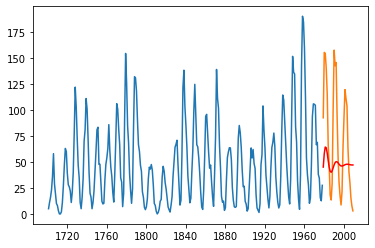

In [ ]:
arma31 = ARIMA(sunspots_train, order=(3, 0, 1)).fit()
pred31 = arma31.predict(start='1978', end='2008', dynamic=True)

plt.plot(sunspots_train)
plt.plot(sunspots_test)
plt.plot(pred31, 'r-')
plt.show()

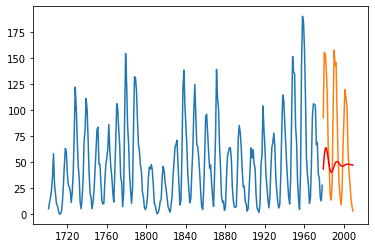

In [ ]:
arma21 = ARIMA(sunspots_train, order=(2, 0, 1)).fit()
pred21 = arma21.predict(start='1978', end='2008', dynamic=True)

plt.plot(sunspots_train)
plt.plot(sunspots_test)
plt.plot(pred21, 'r-')
plt.show()

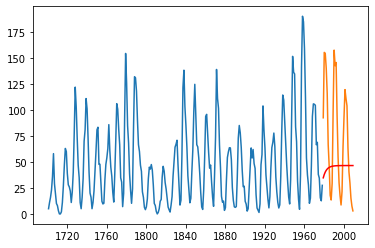

In [ ]:
arma11 = ARIMA(sunspots_train, order=(1, 0, 1)).fit()
pred11 = arma11.predict(start='1978', end='2008', dynamic=True)

plt.plot(sunspots_train)
plt.plot(sunspots_test)
plt.plot(pred11, 'r-')
plt.show()

In [ ]:
#dwa pierwsze modele lepsze od ostatniego, choć żaden z nich nie jest dobry, można np. spróbować SARIMAX

# Predykcja z wykorzystaniem danych historycznych

In [ ]:
#tutaj tworzymy predykcję dla obserwacji na podstawie struktury opisanej w modelu i konkretnych danych, które mają wcześniejsze indeksy czasowe
#w kolejnym kroku nie bierzemy predykcji, którą uzyskaliśmy, tylko prawdziwą wartość szeregu 

In [ ]:
history = sunspots_train.values.tolist()
prediction = []
simple_prediction = []
errors = []
test = sunspots_test.values

for t in range(len(test)):
    model = ARIMA(history, order=(2, 0, 1)).fit()
    pred = model.forecast()[0]
    
    prediction.append(pred[0])
    simple_prediction.append(history[-1][0])
    history.append(test[t])
    
    errors.append((pred[0] - test[t])**2)

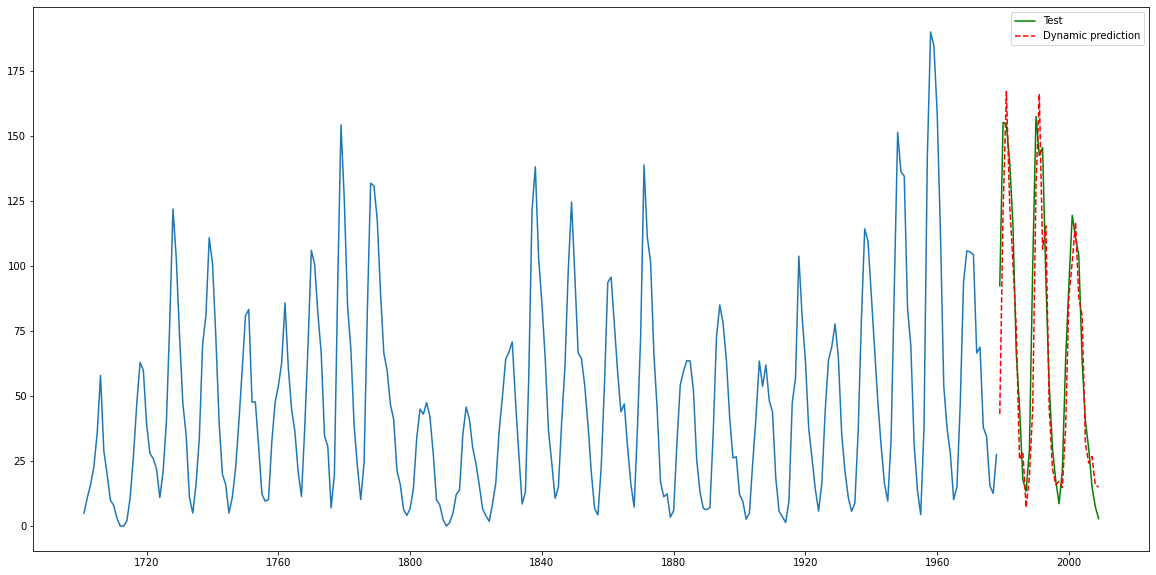

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(sunspots_train)
plt.plot(sunspots_test, 'g-', label="Test")
plt.plot(pd.Series(prediction, index=sunspots_test.index), 'r--', label="Dynamic prediction")
#plt.plot(pd.Series(simple_prediction, index=sunspots_test.index), 'm.-', label="Naive prediction") #naiwna predykcja to wzięcie po prostu 
#wcześniejszej obserwacji jako predykcji następnej
plt.legend()
plt.show()
#widzimy, że predykcja jest przesunięta o 1 - nie jest dobra